# Prediction Model
### MBD S1, Group F

By: Prasanth Chakka | Lina Carrillo | Daniel Bilitewski | Ani Afyan | Andres Behnsen

Content:
1. Preparing the Data
2. Baseline Model
3. Feature Engineering
    1. Feature Creation: Aggregating on School Level
    2. Feature Creation: Aggregation on Association Level
    3. Feature Creation: Adding External Data
    4. Feature Creation: Linear Discriminant Analysis
    5. Feature Creation: Feature Pre-Selection
4. Hyperparameter Tuning
5. Predict on Test Set (Year 2019)

## 1. Preparing the Data
The first step is preparing a unified data set by merging data from all the sources available. The details of this are described in our technical report.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.utils import resample
from imblearn.under_sampling import NearMiss

from functools import reduce

In [2]:
# load data
data_2016 = pd.read_csv('CDS_2016_va.csv')
data_2017 = pd.read_csv('CDS_2017_va.csv')
data_2018 = pd.read_csv('CDS_2018_va.csv')
data_2019 = pd.read_csv('CDS_2019_NO_LABEL.csv')
asignaturas = pd.read_csv('Asignaturas.csv', sep = ';')
clientes = pd.read_csv('Clientes.csv', sep = ';')
cursos = pd.read_csv('Cursos.csv', sep = ';')
lengua = pd.read_csv('Lengua.csv', sep = ';')
tme = pd.read_csv('TME.csv', sep = ';')
ts = pd.read_csv('TS.csv', sep = ';')

In [3]:
# entries in column 'Curso' starts with a 'c' for data_2018
data_2018['Curso'] =  data_2018.Curso.str[1:].astype(int).copy()

# entries in column 'Año natural' are 18 instead of 2018
data_2018['Año natural'] = 2018

# some column labels for data_2016 are different
data_2016.columns = data_2017.columns

# data_2017 has duplicate rows
data_2017.drop_duplicates(subset = None, keep = 'first', inplace = True)

# data_2019 Variable2 seems to be to small by a factor of 100
data_2019['Variable2'] = data_2019['Variable2'] * 100

In [4]:
### Asignatura ###

# remove non-numerical values from the asignatura code
asignaturas = asignaturas.loc[~asignaturas.Asignatura.isin(['EE01', '#']),:].copy()

# convert the asignatura code to integer
asignaturas['Asignatura'] = asignaturas.Asignatura.astype(int).copy()

### Curso ###

# remove non-numerical values from the curso code
cursos = cursos.loc[~cursos.Curso.isin(['#']),:].copy()

# convert the curso code the integer
cursos['Curso'] = cursos.Curso.astype(int).copy()

# keep only relevant columns
cursos = cursos[['Curso', 'N_Curso']].copy()

### TME ###

# remove non-numerical values from the curso code
tme = tme.loc[~tme['Tipo Material Educat'].isin(['#']),:].copy()

# convert the curso code the integer
tme['Tipo Material Educativo'] = tme['Tipo Material Educat'].astype(int).copy()

# drop original column
tme.drop('Tipo Material Educat', axis = 1, inplace = True)

### TS ###

# remove non-numerical values from the curso code
ts = ts.loc[~ts['Tipo Soporte Actual'].isin(['#']),:].copy()

# convert the curso code the integer
ts['Tipo Soporte Actual'] = ts['Tipo Soporte Actual'].astype(int).copy()

In [5]:
# create list with all datasets
datasets = [data_2016, data_2017, data_2018, data_2019]

# loop over this list
for i, data in enumerate(datasets):
    
    # join data
    datasets[i] = datasets[i].merge(asignaturas, how = 'left', on = 'Asignatura')
    datasets[i] = datasets[i].merge(clientes, how = 'left', on = 'Id_Cliente')
    datasets[i] = datasets[i].merge(cursos, how = 'left', on = 'Curso')
    datasets[i] = datasets[i].merge(lengua, how = 'left', on = 'Lengua')
    datasets[i] = datasets[i].merge(tme, how = 'left', on = 'Tipo Material Educativo')
    datasets[i] = datasets[i].merge(ts, how = 'left', on = 'Tipo Soporte Actual')
    
    # create a unique record id
    datasets[i]['record_id'] = list(map(lambda a, b, c, d, e, f: str(a) + '_' + \
                                                                 str(b) + '_' + \
                                                                 str(c) + '_' + \
                                                                 str(d) + '_' + \
                                                                 str(e) + '_' + \
                                                                 str(f),
                                        datasets[i]['Id_Cliente'],
                                        datasets[i]['Curso'],
                                        datasets[i]['Asignatura'],
                                        datasets[i]['Tipo Material Educativo'],
                                        datasets[i]['Lengua'],
                                        datasets[i]['Tipo Soporte Actual']))
    
    # add the record ID of the previous year, which is the same just with Curso being one lower
    datasets[i]['record_id_previous'] = list(map(lambda a, b, c, d, e, f: str(a) + '_' + \
                                                                          str(b - 1) + '_' + \
                                                                          str(c) + '_' + \
                                                                          str(d) + '_' + \
                                                                          str(e) + '_' + \
                                                                          str(f),
                                                 datasets[i]['Id_Cliente'],
                                                 datasets[i]['Curso'],
                                                 datasets[i]['Asignatura'],
                                                 datasets[i]['Tipo Material Educativo'],
                                                 datasets[i]['Lengua'],
                                                 datasets[i]['Tipo Soporte Actual']))
    
    # create a column for non use, use exception throwing because data_2019 doesn't have the 'Grupo Editorial' column
    try:
        # create column name in the form non_use_YYYY
        column_name = 'non_use_' + str(datasets[i]['Año natural'].unique()[0])
        
        # create binary column with 1 where Grupo Editorial = 90 (non-use)
        datasets[i][column_name] = np.where(datasets[i]['Grupo Editorial'] == 90, 1, 0)
        
    except:
        pass

# merge all four dataframes into one on the record_id
target_df = reduce(lambda x, y: pd.merge(x, y, how = 'outer', on = 'record_id'), datasets)

# keep only the non_use columns and the record_id
target_df = target_df[['record_id', 'non_use_2016', 'non_use_2017', 'non_use_2018']].copy()

# create the target 
target_df['target_2017'] = np.where((target_df.non_use_2016 == 0) & (target_df.non_use_2017 == 1), 1, 0)
target_df['target_2018'] = np.where((target_df.non_use_2017 == 0) & (target_df.non_use_2018 == 1), 1, 0)

# add target to dataframes for 2016 and 2017
datasets[1] = datasets[1].merge(target_df[['record_id', 'target_2017']], how = 'left', on = 'record_id')
datasets[2] = datasets[2].merge(target_df[['record_id', 'target_2018']], how = 'left', on = 'record_id')

# rename columns to allow concatenation on these columns
datasets[0] = datasets[0].rename(columns = {'non_use_2016':'non_use'})
datasets[1] = datasets[1].rename(columns = {'non_use_2017':'non_use', 'target_2017':'target'})
datasets[2] = datasets[2].rename(columns = {'non_use_2018':'non_use', 'target_2018':'target'})

# add columns with information from the previous year for the same record_id
datasets[1] = datasets[1].merge(datasets[0][['record_id', 'non_use', 'Grupo Editorial', 'Variable1', 'Variable2']], 
                                how = 'left', 
                                on = 'record_id', 
                                suffixes = ('', '_previous'))

datasets[2] = datasets[2].merge(datasets[1][['record_id', 'non_use', 'Grupo Editorial', 'Variable1', 'Variable2']], 
                                how = 'left', 
                                on = 'record_id', 
                                suffixes = ('', '_previous'))

datasets[3] = datasets[3].merge(datasets[2][['record_id', 'non_use', 'Grupo Editorial', 'Variable1', 'Variable2']], 
                                how = 'left', 
                                on = 'record_id', 
                                suffixes = ('', '_previous'))

# add columns with information from the same class in the previous year
# this means that 3° Primaria was 2° Primaria in the last year
datasets[1] = datasets[1].merge(datasets[0][['record_id', 'non_use', 'Grupo Editorial', 'Variable1', 'Variable2']], 
                                how = 'left', 
                                left_on = 'record_id_previous', 
                                right_on = 'record_id',
                                suffixes = ('', '_previous_year'))

datasets[2] = datasets[2].merge(datasets[1][['record_id', 'non_use', 'Grupo Editorial', 'Variable1', 'Variable2']], 
                                how = 'left', 
                                left_on = 'record_id_previous', 
                                right_on = 'record_id',
                                suffixes = ('', '_previous_year'))

datasets[3] = datasets[3].merge(datasets[2][['record_id', 'non_use', 'Grupo Editorial', 'Variable1', 'Variable2']], 
                                how = 'left', 
                                left_on = 'record_id_previous', 
                                right_on = 'record_id',
                                suffixes = ('', '_previous_year'))

# since non_use and Grupo Editorial don't exist for 2019, 
# we have to rename these columns as the suffix _previous wasn't created properly
datasets[3].rename(columns = {'non_use' : 'non_use_previous',
                              'Grupo Editorial' : 'Grupo Editorial_previous',},
                  inplace = True)

# concatenate data into one dataframe
data = pd.concat(datasets, sort = False, ignore_index = True)

# rename columns
data.rename(columns = {'Id_Cliente' : 'client_id', 
                       'Año natural' : 'year', 
                       'Curso' : 'course_code',
                       'Asignatura' : 'subject_code',
                       'Tipo Material Educativo' : 'material_type_code', 
                       'Grupo Editorial' : 'editorial_group', 
                       'Lengua' : 'language_code',
                       'Tipo Soporte Actual' : 'media_support_code',
                       'Variable1' : 'class_size',
                       'Variable2' : 'monetary_value',
                       'Variable1_previous' : 'class_size_previous',
                       'Variable2_previous' : 'monetary_value_previous',
                       'Variable1_previous_year' : 'class_size_previous_year',
                       'Variable2_previous_year' : 'monetary_value_previous_year',
                       'N_Asignatura' : 'subject_name',
                       'Latitud' : 'latitude', 
                       'Longitud' : 'longitude', 
                       'Comunidad Autónoma' : 'state', 
                       'Id_Asociación' : 'association_id',
                       'Id_Subasociación' : 'subassociation_id', 
                       'Titularidad' : 'school_type', 
                       'N_Curso' : 'course_name', 
                       'N_Lengua' : 'language_name', 
                       'N_TME' : 'material_type_name',
                       'N_TS' : 'media_support_name',
                       'Grupo Editorial_previous' : 'editorial_group_previous',
                       'Grupo Editorial_previous_year' : 'editorial_group_previous_year'},
            inplace = True)

# delete unnecessary variables to free up RAM
del asignaturas, clientes, cursos, lengua, tme, ts, data_2016, data_2017, data_2018, data_2019, datasets, target_df

## 2. Baseline Model
We do a baseline model so that we can determine the impact of different feature creation approaches. 

As data, we use data from 2017 and 2018. We use a normal cross-validation, since due to the way we designed the dataset, this is not time series data. Therefore, we have no issues with using observations from both years in training.

We first create a data preparation function, so we can apply the same set of transformations every time we create features.

Then, we create a function to run a model with cross-validation to have a robust way to estimate the impact of our feature creation steps.

In [6]:
# set train data to be data from 2017 and 2018
train = data.loc[(data.year == 2017) | (data.year == 2018),:].copy()

In [7]:
def data_preparation(train, class_size_params = None, monetary_value_params = None):
    
    ## aditional data cleaning and removing
    
    # drop rows where the record is already a non-user in previous years
    train = train.loc[train.non_use_previous != 1,:].copy()
    
    # fill missing values
    train.loc[train.association_id.isna(), 'association_id'] = 'none'
    train.loc[train.subassociation_id.isna(), 'subassociation_id'] = 'none'
    train.loc[train.editorial_group_previous.isna(), 'editorial_group_previous'] = 'none'
    train.loc[train.editorial_group_previous_year.isna(), 'editorial_group_previous_year'] = 'none'
    train.loc[train.class_size_previous.isna(), 'class_size_previous'] = 0
    train.loc[train.monetary_value_previous.isna(), 'monetary_value_previous'] = 0
    train.loc[train.non_use_previous_year.isna(), 'non_use_previous_year'] = 0
    train.loc[train.class_size_previous_year.isna(), 'class_size_previous_year'] = 0
    train.loc[train.monetary_value_previous_year.isna(), 'monetary_value_previous_year'] = 0
    
    # drop uncessary columns
    train.drop(['client_id', 'year', 'course_code', 'subject_code', 'material_type_code', 'editorial_group', 
                'language_code', 'media_support_code', 'record_id', 'record_id_previous', 'record_id_previous_year',
                'non_use', 'non_use_previous'], axis = 1, inplace = True)
    
    ## group categories for features with a high number of distinct categories
    
    # subject_name
    subjects = train.subject_name.value_counts() 
    mask = train.subject_name.isin(subjects[subjects < 1000].index)
    train.loc[mask, 'subject_name'] = 'Other'
    
    # association_id
    associations = train.association_id.value_counts() 
    mask = train.association_id.isin(associations[associations < 2000].index)
    train.loc[mask, 'association_id'] = 'Other'
    
    # subassociation_id
    sub_associations = train.subassociation_id.value_counts() 
    mask = train.subassociation_id.isin(sub_associations[sub_associations < 1000].index)
    train.loc[mask, 'subassociation_id'] = 'Other'
    
    # editorial_group_previous
    editorial_groups = train.editorial_group_previous.value_counts() 
    mask = train.editorial_group_previous.isin(editorial_groups[editorial_groups < 1000].index)
    train.loc[mask, 'editorial_group_previous'] = 'Other'
    
    # course_name (merge all groups three years or lower into one category)
    mapping = {'3 años' : '< 3 años',
               '2 años' : '< 3 años',
               '1 año' : '< 3 años',
               '0 años': '< 3 años'}
    
    train.course_name = train.course_name.replace(mapping)

    ## remove outliers
    # get the mean and standard deveviation for monetary value and class size if this is the train set
    # if this is the test set, pass the class_size upper bound and monetary_value upper bound as parameters to the function 
    if class_size_params == None:
        # define upper bound as mean + 3 * standard deviation
        class_size_mean = train.class_size.mean()
        class_size_std = train.class_size.std()
        class_size_upper = class_size_mean + 3 * class_size_std
        
        # put parameters in list to return them
        class_size_params = [class_size_mean, class_size_std, class_size_upper]
    else:
        class_size_mean = class_size_params[0]
        class_size_std = class_size_params[1]
        class_size_upper = class_size_params[2]
    
    if monetary_value_params == None:
        # define upper bound as mean + 3 * standard deviation
        monetary_value_mean = train.monetary_value.mean()
        monetary_value_std = train.monetary_value.std()
        monetary_value_upper = monetary_value_mean + 3 * monetary_value_std 
        
        # put parameters in list to return them
        monetary_value_params = [monetary_value_mean, monetary_value_std, monetary_value_upper]
    else:
        monetary_value_mean = monetary_value_params[0]
        monetary_value_std = monetary_value_params[1]
        monetary_value_upper = monetary_value_params[2]

    # define lower bound as 1
    lower = 1

    # remove everything outside of the lower and upper limit
    mask = (train.class_size < lower) | (train.class_size > class_size_upper)
    train.loc[mask, 'class_size'] = class_size_mean
    
    mask = (train.class_size_previous < lower) | (train.class_size_previous > class_size_upper)
    train.loc[mask, 'class_size_previous'] = class_size_mean
    
    mask = (train.class_size_previous_year < lower) | (train.class_size_previous_year > class_size_upper)
    train.loc[mask, 'class_size_previous_year'] = class_size_mean
    
    mask = (train.monetary_value < lower) | (train.monetary_value > monetary_value_upper)
    train.loc[mask, 'class_size'] = monetary_value_mean
    
    mask = (train.monetary_value_previous < lower) | (train.monetary_value_previous > monetary_value_upper)
    train.loc[mask, 'monetary_value_previous'] = monetary_value_mean
    
    mask = (train.monetary_value_previous_year < lower) | (train.monetary_value_previous_year > monetary_value_upper)
    train.loc[mask, 'monetary_value_previous_year'] = monetary_value_mean
    
    ## one-hot encoding
    train = pd.get_dummies(train, 
                           prefix = train.select_dtypes('object').columns, 
                           columns = train.select_dtypes('object').columns,
                           drop_first = False)
    
    # sort columns alphabetically
    train = train[sorted(train.columns)].copy()
    
    return train, class_size_params, monetary_value_params

In [8]:
def run_model(X_train, y_train, baseline_score = None):
    
    # create random forest classifier
    rf = RandomForestClassifier(criterion = 'gini', 
                                n_estimators = 100,
                                max_samples = 0.7,
                                max_depth = 20, 
                                min_samples_split = 0.001, 
                                min_samples_leaf = 0.0001,
                                max_leaf_nodes = 200, 
                                min_impurity_decrease = 0.0001,
                                class_weight = 'balanced')

    # create a cross-validation model with 10 folds and F1 metric
    rf_cv = cross_validate(rf,
                           X_train,
                           y_train,
                           scoring = 'f1',
                           cv = 5,
                           n_jobs = -1)

    # plot boxplot of the test scores for each cross-validation fold
    plt.boxplot(rf_cv['test_score'])
    
    # calculate the baseline roc_auc score with cross-validation
    f1_score_cv = np.mean(rf_cv['test_score'])
    print('F1 Score (cross-validation): {:.3f}'.format(f1_score_cv))

    # if this is not the baseline model, print the improvement in the score, 
    # else return the score so that it can be used as a baseline
    if baseline_score == None:
        return f1_score_cv
    else:
        print('Improvement over baseline: {:.3f}'.format(f1_score_cv - baseline_score))

F1 Score (cross-validation): 0.161


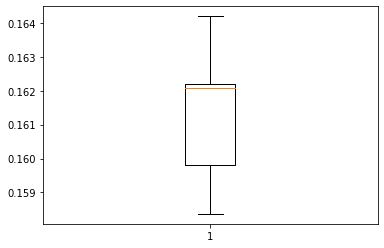

In [9]:
# create train data
X_train, class_size_params, monetary_value_params = data_preparation(train)

# create target
y_train = X_train.target

# drop target from training features
X_train.drop(['target'], axis = 1, inplace = True)

# run model
baseline = run_model(X_train, y_train)

## A. Feature Creation: Aggregating on School Level
We aggregate certain features on the the client_id, which is the school. The hypothesis here is that many decisions are made on a school level, and therefore we can determine these patterns in this way.

The result is almost no improvement over the baseline. The F1 score improved by 0.003.

F1 Score (cross-validation): 0.165
Improvement over baseline: 0.003


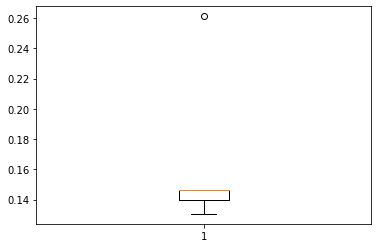

In [10]:
# create train data
X_train = train.copy()

# create feature indicating if the school includes classes from the four age groups
X_train['kindergarden'] = list(map(lambda x: int('años' in x), X_train.course_name)) 
X_train['primary'] = list(map(lambda x: int('Primaria' in x), X_train.course_name))
X_train['secondary'] = list(map(lambda x: int('Secundaria' in x), X_train.course_name))
X_train['highschool'] = list(map(lambda x: int('Bachillerato' in x), X_train.course_name)) 

# create features by grouping on school level
school_level_aggregation = X_train.groupby('client_id').agg(n_courses = ('course_name', 'nunique'),
                                 kindergarden = ('kindergarden', 'max'),
                                 primary = ('primary', 'max'),
                                 secondary = ('secondary', 'max'),
                                 highschool = ('highschool', 'max'),
                                 n_subjects = ('subject_name', 'nunique'),
                                 n_materials = ('material_type_name', 'nunique'),
                                 n_support = ('media_support_name', 'nunique'),
                                 sum_class_size = ('class_size', 'sum'),
                                 avg_class_size = ('class_size', 'mean'),
                                 total_monetary_value = ('monetary_value', 'sum'),
                                 avg_non_use_previous = ('non_use_previous', 'mean'))

# fill missing values
school_level_aggregation.avg_non_use_previous = 0

# join data
X_train = X_train.merge(school_level_aggregation, left_on = 'client_id', right_index = True)

# prepare data
X_train, class_size_params, monetary_value_params = data_preparation(X_train)

# create target
y_train = X_train.target

# drop target from training features
X_train.drop('target', axis = 1, inplace = True)

# run model
run_model(X_train, y_train, baseline_score = baseline)

## B. Feature Creation: Aggregation on Association Level
If not on school level, maybe certain decisions are made on association level. But here, the results are even worse as the model performs worse than the baseline. Due to the bad results so far, we won't try aggregating on sub-association level.

F1 Score (cross-validation): 0.134
Improvement over baseline: -0.027


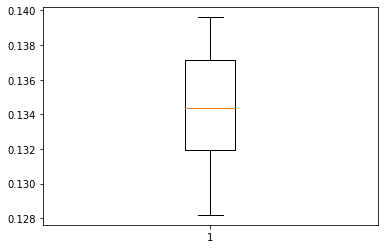

In [11]:
# create train data
X_train = train.copy()

# create features by grouping on school level
association_level_aggregation = X_train.groupby('association_id').agg(n_courses = ('course_name', 'nunique'),
                                 n_subjects = ('subject_name', 'nunique'),
                                 n_materials = ('material_type_name', 'nunique'),
                                 n_support = ('media_support_name', 'nunique'),
                                 sum_class_size = ('class_size', 'sum'),
                                 avg_class_size = ('class_size', 'mean'),
                                 total_monetary_value = ('monetary_value', 'sum'),
                                 avg_non_use_previous = ('non_use_previous', 'mean'))

# fill missing values
association_level_aggregation.avg_non_use_previous = 0

# join data
X_train = X_train.merge(association_level_aggregation, left_on = 'association_id', right_index = True)

# prepare data
X_train, class_size_params, monetary_value_params = data_preparation(X_train)

# create target
y_train = X_train.target

# drop target from training features
X_train.drop('target', axis = 1, inplace = True)

# run model
run_model(X_train, y_train, baseline_score = baseline)

## C. Feature Creation: Adding External Data
Our hypothesis is that a major reason for the switch to non-use is the lack of financial resources. Therefore, autonomous regions with lower GDP might have more classes switching to non-use. 

Adding the GDP per capita of the autonomous regions improved the baseline by only 0.002, so we can say it has no impact.

F1 Score (cross-validation): 0.164
Improvement over baseline: 0.002


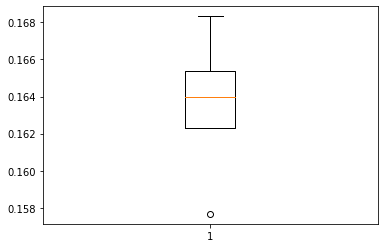

In [12]:
# create train data
X_train = train.copy()

# add external data : GDP per capita for the autonomous regions
# from: https://en.wikipedia.org/wiki/List_of_Spanish_autonomous_communities_by_gross_domestic_product
X_train['gdp_per_capita'] = X_train.state

state_gdp_mapping = {'País Vasco' : 33.223,
                     'Comunidad Valenciana' : 22.426,
                     'Cataluña' : 30.426,
                     'Islas Canarias' : 20.892,
                     'La Rioja' : 27.225,
                     'Navarra' : 31.389,
                     'Madrid' : 35.041}

X_train.gdp_per_capita.replace(state_gdp_mapping, inplace = True)

# prepare data
X_train, class_size_params, monetary_value_params = data_preparation(X_train)

# create target
y_train = X_train.target

# drop target from training features
X_train.drop('target', axis = 1, inplace = True)

# run model
run_model(X_train, y_train, baseline_score = baseline)

## D. Feature Creation: Linear Discriminant Analysis
Linear discriminant analysis is a powerful tool, since it creates a feature based on the training data along which there is the highest seperation of the two classes. 

As predicted, this method proves to be very effective, as it improved the performance by 0.032 over the baseline.

F1 Score (cross-validation): 0.193
Improvement over baseline: 0.032


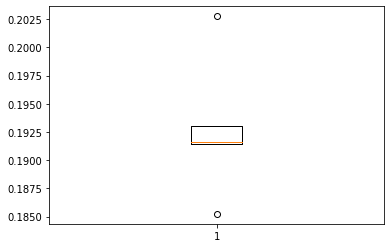

In [13]:
# create train data
X_train = train.copy()

# prepare data
X_train, class_size_params, monetary_value_params = data_preparation(X_train)

# create target
y_train = X_train.target

# drop target from training features
X_train.drop('target', axis = 1, inplace = True)

# create a new feature using linear discriminant analysis
lda = LinearDiscriminantAnalysis()
lda_feature = lda.fit_transform(X_train, y_train)

# create a probability prediction from that feature using a logistic regression model
logit = LogisticRegression(penalty = 'none', solver = 'lbfgs')
logit.fit(lda_feature, y_train)
X_train['lda_feature'] = logit.predict_proba(lda_feature)[:,1]

# run model
run_model(X_train, y_train, baseline_score = baseline)

## E. Feature Creation: Feature Pre-Selection
After one-hot encoding, the training data currently has over 200 columns. Our hypothesis is that some of the features aren't relevant. Therefore, we remove the association_id, the subassociation_id and the editorial group the provided the same the group of children in the previous year when they were one grade lower (e.g. 3° Primaria in 2018 was provided by editorial group 03 when they were 2° Primaria in 2017).

We see that this model has the same performance as the previous model, with an improvement over the baseline of 0.031. Therefore, we won't use these features going forward.

Since we dropped these features, it was necessary to create a variation of the data preparation function that doesn't consider these features.

In [14]:
def data_preparation_2(train, class_size_params = None, monetary_value_params = None):
    
    ## aditional data cleaning and removing
    
    # drop rows where the record is already a non-user in previous years
    train = train.loc[train.non_use_previous != 1,:].copy()
    
    # fill missing values'
    train.loc[train.editorial_group_previous.isna(), 'editorial_group_previous'] = 'none'
    train.loc[train.class_size_previous.isna(), 'class_size_previous'] = 0
    train.loc[train.monetary_value_previous.isna(), 'monetary_value_previous'] = 0
    train.loc[train.non_use_previous_year.isna(), 'non_use_previous_year'] = 0
    train.loc[train.class_size_previous_year.isna(), 'class_size_previous_year'] = 0
    train.loc[train.monetary_value_previous_year.isna(), 'monetary_value_previous_year'] = 0
    
    # drop uncessary columns
    train.drop(['client_id', 'year', 'course_code', 'subject_code', 'material_type_code', 'editorial_group', 
                'language_code', 'media_support_code', 'record_id', 'record_id_previous', 'record_id_previous_year',
                'non_use', 'non_use_previous'], axis = 1, inplace = True)
    
    ## group categories for features with a high number of distinct categories
    
    # subject_name
    subjects = train.subject_name.value_counts() 
    mask = train.subject_name.isin(subjects[subjects < 1000].index)
    train.loc[mask, 'subject_name'] = 'Other'
    
    # editorial_group_previous
    editorial_groups = train.editorial_group_previous.value_counts() 
    mask = train.editorial_group_previous.isin(editorial_groups[editorial_groups < 1000].index)
    train.loc[mask, 'editorial_group_previous'] = 'Other'
    
    # course_name (merge all groups three years or lower into one category)
    mapping = {'3 años' : '< 3 años',
               '2 años' : '< 3 años',
               '1 año' : '< 3 años',
               '0 años': '< 3 años'}
    
    train.course_name = train.course_name.replace(mapping)

    ## remove outliers
    # get the mean and standard deveviation for monetary value and class size if this is the train set
    # if this is the test set, pass the class_size upper bound and monetary_value upper bound as parameters to the function 
    if class_size_params == None:
        # define upper bound as mean + 3 * standard deviation
        class_size_mean = train.class_size.mean()
        class_size_std = train.class_size.std()
        class_size_upper = class_size_mean + 3 * class_size_std
        
        # put parameters in list to return them
        class_size_params = [class_size_mean, class_size_std, class_size_upper]
    else:
        class_size_mean = class_size_params[0]
        class_size_std = class_size_params[1]
        class_size_upper = class_size_params[2]
    
    if monetary_value_params == None:
        # define upper bound as mean + 3 * standard deviation
        monetary_value_mean = train.monetary_value.mean()
        monetary_value_std = train.monetary_value.std()
        monetary_value_upper = monetary_value_mean + 3 * monetary_value_std 
        
        # put parameters in list to return them
        monetary_value_params = [monetary_value_mean, monetary_value_std, monetary_value_upper]
    else:
        monetary_value_mean = monetary_value_params[0]
        monetary_value_std = monetary_value_params[1]
        monetary_value_upper = monetary_value_params[2]

    # define lower bound as 1
    lower = 1

    # remove everything outside of the lowe and upper limit
    mask = (train.class_size < lower) | (train.class_size > class_size_upper)
    train.loc[mask, 'class_size'] = class_size_mean
    
    mask = (train.class_size_previous < lower) | (train.class_size_previous > class_size_upper)
    train.loc[mask, 'class_size_previous'] = class_size_mean
    
    mask = (train.class_size_previous_year < lower) | (train.class_size_previous_year > class_size_upper)
    train.loc[mask, 'class_size_previous_year'] = class_size_mean
    
    mask = (train.monetary_value < lower) | (train.monetary_value > monetary_value_upper)
    train.loc[mask, 'class_size'] = monetary_value_mean
    
    mask = (train.monetary_value_previous < lower) | (train.monetary_value_previous > monetary_value_upper)
    train.loc[mask, 'monetary_value_previous'] = monetary_value_mean
    
    mask = (train.monetary_value_previous_year < lower) | (train.monetary_value_previous_year > monetary_value_upper)
    train.loc[mask, 'monetary_value_previous_year'] = monetary_value_mean
    
    ## one-hot encoding
    train = pd.get_dummies(train, 
                           prefix = train.select_dtypes('object').columns, 
                           columns = train.select_dtypes('object').columns,
                           drop_first = False)
    
    # sort columns alphabetically
    train = train[sorted(train.columns)].copy()
    
    return train, class_size_params, monetary_value_params

F1 Score (cross-validation): 0.193
Improvement over baseline: 0.031


array([[124081,  53465],
       [  1362,   6634]], dtype=int64)

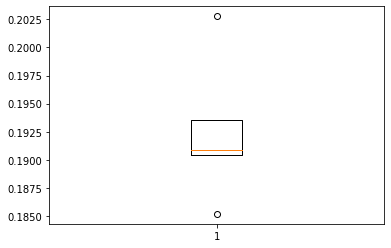

In [15]:
# create train data
X_train = train.copy()

# drop features
X_train.drop(['editorial_group_previous_year', 'association_id', 'subassociation_id'], axis = 1, inplace = True)

# prepare data
X_train, class_size_params, monetary_value_params = data_preparation_2(X_train)

# create target
y_train = X_train.target

# drop target from training features
X_train.drop('target', axis = 1, inplace = True)

# create a new feature using linear discriminant analysis
lda = LinearDiscriminantAnalysis()
lda_feature = lda.fit_transform(X_train, y_train)

# create a probability prediction from that feature using a logistic regression model
logit = LogisticRegression(penalty = 'none', solver = 'lbfgs')
logit.fit(lda_feature, y_train)
X_train['lda_feature'] = logit.predict_proba(lda_feature)[:,1]

# run model
run_model(X_train, y_train, baseline_score = baseline)



X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size = 0.2,
                                                    stratify = y_train,
                                                    random_state = 12)

rf = RandomForestClassifier(criterion = 'gini', 
                                n_estimators = 100,
                                max_samples = 0.7,
                                max_depth = 20, 
                                min_samples_split = 0.001, 
                                min_samples_leaf = 0.0001,
                                max_leaf_nodes = 200, 
                                min_impurity_decrease = 0.0001,
                                class_weight = 'balanced',
                                n_jobs = -1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

confusion_matrix(y_test, y_pred)

## 4. Hyperparameter Tuning
The feature creation process showed us the best results when we removed the association_id, the subassociation_id and the editorial group of the same class in the previous year, as well as doing a linear discrimant analysis. Therefore, with this feature creation we will find the best hyperparameters for the random forest classifier.

In [16]:
# create train data
X_train = train.copy()

# drop features
X_train.drop(['editorial_group_previous_year', 'association_id', 'subassociation_id'], axis = 1, inplace = True)

# prepare data
X_train, class_size_params, monetary_value_params = data_preparation_2(X_train)

# create target
y_train = X_train.target

# drop target from training features
X_train.drop('target', axis = 1, inplace = True)

# create a new feature using linear discriminant analysis
lda = LinearDiscriminantAnalysis()
lda_feature = lda.fit_transform(X_train, y_train)

# create a probability prediction from that feature using a logistic regression model
logit = LogisticRegression(penalty = 'none', solver = 'lbfgs')
logit.fit(lda_feature, y_train)
X_train['lda_feature'] = logit.predict_proba(lda_feature)[:,1]

# define parameter grid 
params = {
    'max_depth' : [20, 25], 
    'min_samples_leaf' : [0.0001, 0], 
    'min_impurity_decrease' : [0.0001, 0],
}

# create random forest model
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 100,
                            max_samples = 0.7,
                            class_weight = 'balanced'
                           )

# create grid search object
grid_rf = GridSearchCV(estimator = rf, 
                       param_grid = params, 
                       scoring = 'f1',
                       n_jobs = -1,
                       cv = 3,
                       refit = True,
                       return_train_score = True,
                       verbose = 1)

# fit the model
grid_rf.fit(X_train, y_train)

# read results of grid search into dataframe
cv_results_df = pd.DataFrame(grid_rf.cv_results_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  7.4min finished


In [17]:
pd.options.display.max_colwidth = 100
cv_results_df[['params', 'mean_train_score', 'mean_test_score']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_train_score,mean_test_score
6,"{'max_depth': 25, 'min_impurity_decrease': 0, 'min_samples_leaf': 0.0001}",0.225889,0.205941
2,"{'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_leaf': 0.0001}",0.217966,0.202602
0,"{'max_depth': 20, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 0.0001}",0.195385,0.193162
4,"{'max_depth': 25, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 0.0001}",0.195062,0.192919
1,"{'max_depth': 20, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 0}",NaN,NaN
3,"{'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_leaf': 0}",NaN,NaN
5,"{'max_depth': 25, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 0}",NaN,NaN
7,"{'max_depth': 25, 'min_impurity_decrease': 0, 'min_samples_leaf': 0}",NaN,NaN


## 5. Predict on Test Set (Year 2019)
Having the model with the best hyperparameters, we can apply the same feature creation process to the data from year 2019 and use the model to make a prediction.

In [26]:
test = data.loc[data.year == 2019,:].copy()

# create test data
X_test = test.copy()

# drop features
X_test.drop(['editorial_group_previous_year', 'association_id', 'subassociation_id', 'target'], axis = 1, inplace = True)

# prepare data (we pass the upper bounds for class size and monetary value to remove outliers)
X_test, class_size_params, monetary_value_params = data_preparation_2(X_test, class_size_params = class_size_params, monetary_value_params = monetary_value_params)

# fill columns that exist in the train set but don't exist in the test set
columns_fill = set(X_train.columns).difference(set(X_test.columns)).difference(set(['lda_feature']))
for col in columns_fill:
    X_test[col] = 0
print(f'Added columns: {columns_fill}')    

# sort columns
X_test = X_test[sorted(X_test.columns)].copy()

# create a new feature using the linear discriminant model
lda_feature = lda.transform(X_test)

# create a probability prediction from that feature using the logistic regression model
X_test['lda_feature'] = logit.predict_proba(lda_feature)[:,1]

# predict on test set
predictions = grid_rf.best_estimator_.predict(X_test)

# add to prediction data and join with raw test set
X_test['Change_to_non_use'] = predictions
test = test.merge(X_test['Change_to_non_use'], how = 'left', left_index = True, right_index = True)

# missing values are those that were already non_use in the previous year, therefore the target must be zero
test.loc[test.Change_to_non_use.isna(),'Change_to_non_use'] = 0

# keep only the columns in the original data and rename to their original names
test = test[['client_id', 'year', 'course_code', 'subject_code', 'material_type_code', 
             'language_code', 'media_support_code', 'class_size', 'monetary_value', 'Change_to_non_use']].copy()

test.rename({'client_id' : 'Id_Cliente', 
             'year' : 'Año natural', 
             'course_code' : 'Curso', 
             'subject_code' : 'Asignatura', 
             'material_type_code' : 'Tipo Material Educativo', 
             'language_code' : 'Lengua', 
             'media_support_code' : 'Tipo Soporte Actual', 
             'class_size' : 'Variable1', 
             'monetary_value' : 'Variable2'},
           inplace = True)

# write data to csv
test.to_csv('GroupF_Predictions.csv', index = False)

Added columns: {'subject_name_Diccionarios Escolares', 'subject_name_Tecnologías de la información', 'subject_name_Music', 'subject_name_PMAR (Social)', 'subject_name_Plan lector', 'subject_name_Biology and Geology', 'subject_name_Griego', 'subject_name_Informática', 'subject_name_Science', 'subject_name_PMAR (Técnico)', 'subject_name_Competencias básicas', 'editorial_group_previous_22.0', 'subject_name_Geography and History', 'subject_name_Ciencias de la tierra y medio', 'subject_name_Vacaciones'}
